In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from selectinf.Simulation.spline import cubic_spline, b_spline
from selectinf.Simulation.H1.nonlinear_H1_helpers import *
from selectinf.RealDataHelpers.rdhelpers import *
from sklearn.decomposition import PCA

In [2]:
fpw = pd.read_csv("fpw.csv", index_col=0)

In [3]:
fpw

,day,dep_delay,distance,plane_age,seats,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,sched_dep_hour,sched_arr_hour
0,1,28.0,187,18.0,20,42.0,30.0,62.18,360.0,9.20624,10.594357,0.00,1017.8,10.00,23,0
1,1,-12.0,1576,21.0,200,42.0,30.0,62.18,360.0,9.20624,10.594357,0.00,1017.8,10.00,23,4
2,1,6.0,1041,18.0,20,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8,11
3,1,-7.0,1182,24.0,145,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8,10
4,1,-4.0,1029,22.0,145,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435,27,-3.0,187,11.0,200,42.0,41.0,96.21,0.0,0.00000,0.000000,0.00,1019.2,1.50,5,6
8436,27,2.0,1089,1.0,185,42.0,41.0,96.21,0.0,0.00000,0.000000,0.00,1019.2,1.50,5,8
8437,16,240.0,1089,7.0,189,26.0,23.0,88.23,330.0,4.60312,5.297178,0.01,1020.9,1.25,5,8
8438,27,-5.0,209,17.0,95,42.0,39.0,89.01,160.0,4.60312,5.297178,0.00,1023.2,10.00,23,0


In [4]:
fpw["precip"].unique()

array([0.    , 0.01  , 0.02  , 0.03  , 0.0001, 0.04  ])

In [5]:
Y = fpw["dep_delay"]
X = fpw.drop(["dep_delay", 'day', "wind_gust"], axis=1)

In [6]:
X.shape

(7358, 13)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.9,
                                                    random_state=42)
# Standardize
#x_train = (x_train - x_train.mean()) / x_train.std()
#x_test = (x_test - x_train.mean()) / x_train.std()

# Construct splines

In [8]:
def get_splines(x_nl, x_l, nknots, degree, intercept):
    bs = b_spline(data_nl=np.array(x_nl), data_l=np.array(x_l), 
                  nknots=nknots, degree=degree, intercept=intercept)
    bs.construct_splines(use_quantiles=True, equally_spaced=False, center=False)
    design_train = bs.get_spline_data()
    design_train *= np.sqrt(design_train.shape[0])
    design_train[:, 0] = 1
    # Returning group labels with 0 meaning the intercept (if applicable)
    groups = bs.get_groups()

    return design_train, groups


In [9]:
linear = list(x_train.columns[x_train.nunique() < 40])

In [10]:
x_train.nunique()

distance           59
plane_age          31
seats              26
temp               41
dewp               52
humid             230
wind_dir           36
wind_speed         21
precip              6
pressure          217
visib              19
sched_dep_hour     18
sched_arr_hour     21
dtype: int64

In [11]:
x_train_nl = x_train.drop(linear, axis=1)
x_train_l_temp = x_train[linear]
x_test_nl = x_test.drop(linear, axis=1)
x_test_l = x_test[linear]
n_train = x_train_l_temp.shape[0]
n_test = x_test_l.shape[0]

x_train_l = (x_train_l_temp - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_train))
x_test_l = (x_test_l - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_test))

In [12]:
x_test_l.std()

plane_age         0.012439
seats             0.012695
wind_dir          0.012015
wind_speed        0.012213
precip            0.011678
visib             0.012367
sched_dep_hour    0.012716
sched_arr_hour    0.012545
dtype: float64

In [13]:
x_train_l.std()

plane_age         0.036886
seats             0.036886
wind_dir          0.036886
wind_speed        0.036886
precip            0.036886
visib             0.036886
sched_dep_hour    0.036886
sched_arr_hour    0.036886
dtype: float64

In [14]:
design_train, groups_train = (
        get_splines(x_train_nl, x_train_l, nknots=6, degree=2, intercept=True))
design_test, groups_test = (
        get_splines(x_test_nl, x_test_l, nknots=6, degree=2, intercept=True))

Equally spaced quantile knots used.
Equally spaced quantile knots used.


In [15]:
# Steps:
# 1. Transform training fully for naive and MLE
# 2. Transform 90% of training for data splitting's selection
# 3. Use 10% of remaining to get the transformed PCs for data splitting's inference
# 4. 

In [16]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.31064035,  0.48803806],
       [ 1.        , -1.19756794, -0.48768174, ...,  0.49814698,
         0.5246241 ,  0.86247227],
       [ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.73860785,  0.86247227],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ..., -1.32841514,
         0.0966566 ,  0.30082095],
       [ 1.        , -1.51037039, -0.5800947 , ..., -0.23247787,
         0.31064035,  0.67525517],
       [ 1.        , -0.22672314,  1.29537708, ...,  0.49814698,
        -0.75927839, -0.63526457]])

In [17]:
design_train.T @ design_train

array([[ 7.35000000e+02, -3.67100058e+02,  4.59106234e+02,
        -4.33438163e+02, -7.45968241e+01, -4.59180683e+02,
        -1.26910180e+02, -5.45186805e+02, -2.82949388e+02,
        -3.33743647e+02,  1.22029202e+02, -4.39648318e-14,
         8.88178420e-16,  7.46069873e-14,  2.30926389e-14,
         7.99360578e-15,  3.55271368e-15,  8.34887715e-14,
        -2.13162821e-14],
       [-3.67100058e+02,  7.35000000e+02,  2.04281037e-14,
         2.80018211e+02,  2.37180387e+01,  2.73259862e+02,
         7.53470033e+01,  2.84940969e+02,  1.49968697e+02,
         1.55389995e+02, -6.42800149e+01,  1.61092469e+01,
        -2.55856216e+02, -9.41992913e+00,  1.66531060e+01,
        -1.37017392e+01,  1.08940864e+01, -5.32271236e+00,
        -2.23713029e+01],
       [ 4.59106234e+02,  2.04281037e-14,  7.35000000e+02,
        -2.48589798e+02, -7.28982263e+01, -2.58679981e+02,
        -1.07045308e+02, -3.22637687e+02, -1.94284345e+02,
        -2.40647586e+02,  3.92143608e+01,  9.96624583e+01,
    

In [18]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.31064035,  0.48803806],
       [ 1.        , -1.19756794, -0.48768174, ...,  0.49814698,
         0.5246241 ,  0.86247227],
       [ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.73860785,  0.86247227],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ..., -1.32841514,
         0.0966566 ,  0.30082095],
       [ 1.        , -1.51037039, -0.5800947 , ..., -0.23247787,
         0.31064035,  0.67525517],
       [ 1.        , -0.22672314,  1.29537708, ...,  0.49814698,
        -0.75927839, -0.63526457]])

In [19]:
design_train.std(axis=0)

array([0.        , 0.86633933, 0.78091738, 0.80761377, 0.99483633,
       0.78083635, 0.98498027, 0.67067564, 0.92293111, 0.89096449,
       0.98612135, 0.9993195 , 0.9993195 , 0.9993195 , 0.9993195 ,
       0.9993195 , 0.9993195 , 0.9993195 , 0.9993195 ])

In [20]:
design_test.std(axis=0)

array([0.        , 0.87850686, 0.78465437, 0.79840987, 0.99396775,
       0.77836609, 0.98646269, 0.67557672, 0.92621893, 0.88931565,
       0.98917161, 1.01222734, 1.03310309, 0.97769863, 0.99383786,
       0.95030807, 1.00635762, 1.0347683 , 1.02083753])

In [87]:
const = group_lasso.gaussian
result_naive, nonzero_naive, selected_groups_naive, soln \
    = naive_inference_real_data(X=design_train, Y=np.array(y_train), 
                                raw_data=np.array(x_train), 
                                groups=groups_train, const=const,
                                n_features=x_train.shape[1], 
                                intercept=True, weight_frac=0.3, level=0.9,
                                mode="weakhierarchy", root_n_scaled=False)

Selected groups: [0, 2, 5, 6, 7, 8, 9, 11, 12, 13]
Naive Selected Groups: 10


In [88]:
pd.DataFrame(result_naive)[pd.DataFrame(result_naive)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
9,1,2,0.005942,0.020583,0.013262,0.002847
14,1,7,-0.256408,-0.038172,-0.147290,0.026208
23,2,7,-0.015090,-0.001422,-0.008256,0.046630
26,2,11,-0.018790,-0.000907,-0.009848,0.069669
30,3,6,0.001421,0.013735,0.007578,0.042655
34,3,11,-0.409781,-0.132192,-0.270987,0.001302
42,4,11,-0.144185,-0.030029,-0.087107,0.011955
58,7,9,0.014887,0.227377,0.121132,0.060417
61,7,12,-0.279672,-0.002405,-0.141039,0.093828
67,9,11,0.023962,0.229241,0.126601,0.042209


In [89]:
result_MLE, nonzero_MLE, selected_groups_MLE, soln_MLE\
    = MLE_inference_real_data(X=design_train, Y=np.array(y_train), 
                              raw_data=np.array(x_train), groups=groups_train, 
                              n_features=x_train.shape[1], 
                              intercept=True, weight_frac=0.3, level=0.9, 
                              mode="weakhierarchy", 
                              root_n_scaled=False, proportion=0.9)

Selected groups: [0, 1, 2, 5, 6, 7, 8, 9, 11, 12, 13]
MLE Selected Groups: 11


In [90]:
pd.DataFrame(result_MLE)[pd.DataFrame(result_MLE)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,0.000210,0.001797,0.001003,0.037588
2,0,3,0.000180,0.001504,0.000842,0.036344
10,0,11,-0.002719,-0.000228,-0.001474,0.051653
11,0,12,0.000816,0.002964,0.001890,0.003793
12,1,2,0.007387,0.022756,0.015072,0.001255
13,1,3,0.004517,0.169278,0.086898,0.082732
17,1,7,-0.256175,-0.034678,-0.145426,0.030781
24,2,5,-0.007706,-0.000323,-0.004015,0.073662
26,2,7,-0.016092,-0.001281,-0.008686,0.053679
30,2,12,0.000450,0.015981,0.008216,0.081817


# Validate significant interactions on a holdout set

In [91]:
def validate(x_test, design_test, y_test, nonzero, selected_groups, 
             groups = None, n_features=None, intercept=True, mode="allpairs", level=0.9):
    X_E = design_test[:, nonzero]
    active_flag = np.zeros(np.unique(groups).shape[0])
    active_flag[selected_groups] = 1.
    raw_data=np.array(x_test)

    if intercept:
        active_vars_flag = active_flag[1:]
    else:
        active_vars_flag = active_flag

    data_interaction = {}
    task_idx = []
    for i in range(n_features):
        for j in range(i + 1, n_features):
            if mode == "allpairs":
                task_idx.append((i, j))
                data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]
            elif mode == 'weakhierarchy':
                if active_vars_flag[i] or active_vars_flag[j]:
                    task_idx.append((i, j))
                    data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]
            elif mode == 'stronghierarchy':
                if active_vars_flag[i] and active_vars_flag[j]:
                    task_idx.append((i, j))
                    data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]

    result_dict = interaction_t_tests_all(X_E, y_test, n_features,
                                          active_vars_flag, data_interaction,
                                          level=level, mode=mode)

    return result_dict

In [92]:
result_naive_validate = validate(x_test, design_test, y_test, nonzero_naive, 
                                 selected_groups_naive, groups = groups_train, 
                                 n_features=x_train.shape[1],
                                 intercept=True, mode="weakhierarchy", level=0.9)

In [93]:
pd.DataFrame(result_naive_validate)

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,-0.000095,0.000094,-6.486249e-07,0.990986
1,0,4,-0.000032,0.000071,1.938177e-05,0.535395
2,0,5,-0.000032,0.000011,-1.074883e-05,0.410731
3,0,6,-0.000002,0.000010,4.231314e-06,0.251963
4,0,7,-0.000074,0.000162,4.409881e-05,0.539246
...,...,...,...,...,...,...
67,9,11,-0.067831,-0.022459,-4.514489e-02,0.001062
68,9,12,-0.033269,0.005891,-1.368888e-02,0.250087
69,10,11,-0.124127,0.026494,-4.881667e-02,0.286263
70,10,12,-0.121909,0.007219,-5.734475e-02,0.143977


In [94]:
result_MLE_validate = validate(x_test, design_test, y_test, nonzero_MLE, 
                                 selected_groups_MLE, groups = groups_train, 
                                 n_features=x_train.shape[1],
                                 intercept=True, mode="weakhierarchy", level=0.9)

In [95]:
pd.DataFrame(result_MLE_validate)

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,-0.000153,0.000180,0.000014,0.891593
1,0,2,-0.000039,-0.000009,-0.000024,0.009601
2,0,3,0.000157,0.000429,0.000293,0.000392
3,0,4,-0.000038,0.000135,0.000049,0.355616
4,0,5,-0.000105,-0.000009,-0.000057,0.052592
...,...,...,...,...,...,...
70,9,11,-0.067172,-0.021798,-0.044485,0.001257
71,9,12,-0.032919,0.006233,-0.013343,0.262161
72,10,11,-0.121028,0.029642,-0.045693,0.318380
73,10,12,-0.121492,0.007605,-0.056944,0.146705


In [96]:
naive_df = pd.DataFrame(result_naive)
naive_significant = \
    [(naive_df["i"][k], naive_df["j"][k]) for k in range(naive_df.shape[0])
     if naive_df["pval"][k] < 0.1]
naive_insig = \
    [(naive_df["i"][k], naive_df["j"][k]) for k in range(naive_df.shape[0])
     if naive_df["pval"][k] >= 0.1]

In [97]:
naive_test_df = pd.DataFrame(result_naive_validate)
naive_test_significant = \
    [(naive_test_df["i"][k], naive_test_df["j"][k]) for k in range(naive_test_df.shape[0])
     if naive_test_df["pval"][k] < 0.1]
naive_test_insig = \
    [(naive_test_df["i"][k], naive_test_df["j"][k]) for k in range(naive_test_df.shape[0])
     if naive_test_df["pval"][k] >= 0.1]

In [98]:
naive_all = [(naive_test_df["i"][k], naive_test_df["j"][k]) 
             for k in range(naive_test_df.shape[0])]

In [99]:
len(set(naive_test_significant).intersection(set(naive_significant))) / len(set(naive_significant))

0.2727272727272727

In [100]:
len(set(naive_test_insig).intersection(set(naive_insig))) / len(set(naive_test_insig))

0.8181818181818182

In [101]:
MLE_df = pd.DataFrame(result_MLE)
MLE_significant = \
    [(MLE_df["i"][k], MLE_df["j"][k]) for k in range(MLE_df.shape[0])
     if MLE_df["pval"][k] < 0.1]
MLE_insig = \
    [(MLE_df["i"][k], MLE_df["j"][k]) for k in range(MLE_df.shape[0])
     if MLE_df["pval"][k] >= 0.1]

In [102]:
len(MLE_significant)

25

In [103]:
MLE_test_df = pd.DataFrame(result_MLE_validate)
MLE_test_significant = \
    [(MLE_test_df["i"][k], MLE_test_df["j"][k]) for k in range(MLE_test_df.shape[0])
     if MLE_test_df["pval"][k] < 0.1]
MLE_test_insig = \
    [(MLE_test_df["i"][k], MLE_test_df["j"][k]) for k in range(MLE_test_df.shape[0])
     if MLE_test_df["pval"][k] >= 0.1]

In [104]:
MLE_all = [(MLE_test_df["i"][k], MLE_test_df["j"][k]) 
             for k in range(MLE_test_df.shape[0])]

In [105]:
alpha = 0.1
naive_train = [(naive_df["pval"][k] < alpha) for k in range(naive_df.shape[0])]
naive_test = [(naive_test_df["pval"][k] < alpha) for k in range(naive_test_df.shape[0])]

In [106]:
from sklearn.metrics import confusion_matrix
# tn, fp, 
# fn, tp
confusion_matrix(naive_test, naive_train)

array([[36,  8],
       [25,  3]])

In [107]:
from sklearn.metrics import f1_score
f1_score(naive_test, naive_train)

0.15384615384615385

In [108]:
MLE_train = [(MLE_df["pval"][k] < alpha) for k in range(MLE_df.shape[0])]
MLE_test = [(MLE_test_df["pval"][k] < alpha) for k in range(MLE_test_df.shape[0])]

In [109]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# tn, fp, 
# fn, tp
confusion_matrix(MLE_test, MLE_train)

array([[29, 12],
       [21, 13]])

In [110]:
tn, fp = confusion_matrix(MLE_test, MLE_train)[0]
fn, tp = confusion_matrix(MLE_test, MLE_train)[1]

In [111]:
tn, fp, fn, tp

(29, 12, 21, 13)

In [112]:
recall_score(MLE_test, MLE_train)

0.38235294117647056

In [74]:
from sklearn.metrics import f1_score
f1_score(MLE_test, MLE_train)

0.10810810810810811

In [75]:
len(set(MLE_test_significant).intersection(set(MLE_significant)))# / len(MLE_test_significant)

2

In [76]:
def predict(beta_hat, X_test):
    return X_test.dot(beta_hat)

In [77]:
len(set(MLE_test_insig).intersection(set(MLE_insig)))# / len(set(MLE_test_insig))

22

In [78]:
X.columns

Index(['distance', 'plane_age', 'seats', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'precip', 'pressure', 'visib', 'sched_dep_hour',
       'sched_arr_hour'],
      dtype='object')

# Repeated subsampling

In [113]:
def subsampling_inference(Y, X, test_size, n_rep, alpha = 0.1):
    
    f1_dict = {"method":[], "F1":[], "Precision":[], "Recall":[]}
    MSE_dict = {"method":[], "MSE_test":[], "MSE_train":[]}
    main_effects_freq_Naive = {name: 0 for name in X.columns}
    interaction_freq_Naive = {}
    main_effects_freq_MLE = {name: 0 for name in X.columns}
    interaction_freq_MLE = {}
    
    for i in range(n_rep):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=test_size,
                                                            random_state=i)
    
        linear = list(x_train.columns[x_train.nunique() < 40])
        x_train_nl = x_train.drop(linear, axis=1)
        x_train_l_temp = x_train[linear]
        x_test_nl = x_test.drop(linear, axis=1)
        x_test_l = x_test[linear]
        n_train = x_train_l_temp.shape[0]
        n_test = x_test_l.shape[0]
        
        x_train_l = (x_train_l_temp - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_train))
        x_test_l = (x_test_l - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_test))
        design_train, groups_train = (
            get_splines(x_train_nl, x_train_l, nknots=6, degree=2, intercept=True))
        design_test, groups_test = (
            get_splines(x_test_nl, x_test_l, nknots=6, degree=2, intercept=True))

        names_map = {i: None for i in range(X.shape[1])}
        for i in range(len(x_train_nl.columns)):
            names_map[i] = x_train_nl.columns[i]
        for j in range(len(x_train_nl.columns),
                       len(x_train_nl.columns) + len(x_train_l.columns)):
            names_map[j] = x_train_l.columns[j - len(x_train_nl.columns)]
        print(names_map)
    
        const = group_lasso.gaussian
    
    
        result_naive, nonzero_naive, selected_groups_naive, soln_naive \
            = naive_inference_real_data(X=design_train, Y=np.array(y_train),
                                        raw_data=np.array(x_train),
                                        groups=groups_train, const=const,
                                        n_features=x_train.shape[1],
                                        intercept=True, weight_frac=0.5, level=0.9,
                                        mode="weakhierarchy", root_n_scaled=False)
        
        result_MLE, nonzero_MLE, selected_groups_MLE, soln_MLE \
            = MLE_inference_real_data(X=design_train, Y=np.array(y_train),
                                      raw_data=np.array(x_train), groups=groups_train,
                                      n_features=x_train.shape[1],
                                      intercept=True, weight_frac=0.5, level=0.9,
                                      mode="weakhierarchy",
                                      root_n_scaled=False, proportion=0.9)
        
        if result_naive is not None:
            for g in selected_groups_naive:
                if g != 0:
                    main_effects_freq_Naive[names_map[g-1]] += 1
    
            result_naive_validate = validate(x_test, design_test, y_test, nonzero_naive,
                                             selected_groups_naive, groups=groups_train,
                                             n_features=x_train.shape[1],
                                             intercept=True, mode="weakhierarchy", level=0.9)
            naive_df = pd.DataFrame(result_naive)
            naive_test_df = pd.DataFrame(result_naive_validate)
            naive_train = [(naive_df["pval"][k] < alpha) for k in range(naive_df.shape[0])]
            naive_test = [(naive_test_df["pval"][k] < alpha) for k in range(naive_test_df.shape[0])]
            f1_dict["method"].append("Naive")
            f1_dict["F1"].append(f1_score(naive_test, naive_train))
            f1_dict["Precision"].append(precision_score(naive_test, naive_train))
            f1_dict["Recall"].append(recall_score(naive_test, naive_train))
            
            for index, row in naive_df.iterrows():
                if row["pval"] < alpha:
                    i = row["i"]
                    j = row["j"]
                    if (names_map[i], names_map[j]) in interaction_freq_Naive.keys():
                        interaction_freq_Naive[(names_map[i], names_map[j])] += 1
                    elif (names_map[j], names_map[i]) in interaction_freq_Naive.keys():
                        interaction_freq_Naive[(names_map[j], names_map[i])] += 1
                    else:
                        interaction_freq_Naive[(names_map[i], names_map[j])] = 1
            
        else:
            f1_dict["method"].append("Naive")
            f1_dict["F1"].append(0)
            f1_dict["Precision"].append(0)
            f1_dict["Recall"].append(0)
    
        if result_MLE is not None:
            for g in selected_groups_MLE:
                if g != 0:
                    main_effects_freq_MLE[names_map[g-1]] += 1
            result_MLE_validate = validate(x_test, design_test, y_test, nonzero_MLE,
                                           selected_groups_MLE, groups=groups_train,
                                           n_features=x_train.shape[1],
                                           intercept=True, mode="weakhierarchy", level=0.9)
        
            MLE_df = pd.DataFrame(result_MLE)
            MLE_test_df = pd.DataFrame(result_MLE_validate)
            MLE_train = [(MLE_df["pval"][k] < alpha) for k in range(MLE_df.shape[0])]
            MLE_test = [(MLE_test_df["pval"][k] < alpha) for k in range(MLE_test_df.shape[0])]
            f1_dict["method"].append("MLE")
            f1_dict["F1"].append(f1_score(MLE_test, MLE_train))
            f1_dict["Precision"].append(precision_score(MLE_test, MLE_train))
            f1_dict["Recall"].append(recall_score(MLE_test, MLE_train))
            
            for index, row in MLE_df.iterrows():
                if row["pval"] < alpha:
                    i = row["i"]
                    j = row["j"]
                    if (names_map[i], names_map[j]) in interaction_freq_MLE.keys():
                        interaction_freq_MLE[(names_map[i], names_map[j])] += 1
                    elif (names_map[j], names_map[i]) in interaction_freq_MLE.keys():
                        interaction_freq_MLE[(names_map[j], names_map[i])] += 1
                    else:
                        interaction_freq_MLE[(names_map[i], names_map[j])] = 1
        else:
            f1_dict["method"].append("MLE")
            f1_dict["F1"].append(0)
            f1_dict["Precision"].append(0)
            f1_dict["Recall"].append(0)
        
        MSE_naive = np.mean((y_test - predict(soln_naive, design_test))**2)
        MSE_naive_train = np.mean((y_train - predict(soln_naive, design_train))**2)
        MSE_MLE = np.mean((y_test - predict(soln_MLE, design_test))**2)
        MSE_MLE_train = np.mean((y_train - predict(soln_MLE, design_train))**2)
        MSE_dict["method"].append("Naive")
        MSE_dict["MSE_test"].append(MSE_naive)
        MSE_dict["MSE_train"].append(MSE_naive_train)
        MSE_dict["method"].append("MLE")
        MSE_dict["MSE_test"].append(MSE_MLE)
        MSE_dict["MSE_train"].append(MSE_MLE_train)
        
    return (f1_dict, MSE_dict, interaction_freq_Naive, interaction_freq_MLE,
            main_effects_freq_Naive, main_effects_freq_MLE)
    

In [129]:
(f1_dict, MSE_dict, interaction_freq_Naive, interaction_freq_MLE,
            main_effects_freq_Naive, main_effects_freq_MLE)\
    = subsampling_inference(Y, X, test_size=0.9, n_rep=100, alpha=0.1)

Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 2, 3, 5, 6, 8, 9, 11, 12]
Naive Selected Groups: 9
Selected groups: [0, 3, 5, 6, 8, 9, 11, 12]
MLE Selected Groups: 8
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 2, 5, 7, 11, 12]
Naive Selected Groups: 6
Selected groups: [0, 1, 2, 5, 7, 11, 12]
MLE Selected Groups: 7
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 1, 2, 5, 9, 11, 12]
Naive Selected Groups: 7
Selected groups: [0, 1, 2, 5, 9, 11, 12]
MLE Selected Groups: 7


/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'dewp', 2: 'humid', 3: 'pressure', 4: 'plane_age', 5: 'seats', 6: 'temp', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 4, 6, 7, 8, 11, 12, 13]
Naive Selected Groups: 8
Selected groups: [0, 2, 4, 6, 7, 8, 11, 12, 13]
MLE Selected Groups: 9
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 2, 5, 7, 9, 11, 12]
Naive Selected Groups: 7
Selected groups: [0, 2, 5, 7, 9, 11, 12]
MLE Selected Groups: 7
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed'

In [124]:
X.columns

Index(['distance', 'plane_age', 'seats', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'precip', 'pressure', 'visib', 'sched_dep_hour',
       'sched_arr_hour'],
      dtype='object')

In [71]:
f1_dict.keys()

dict_keys(['method', 'F1'])

<Axes: xlabel='method', ylabel='F1'>

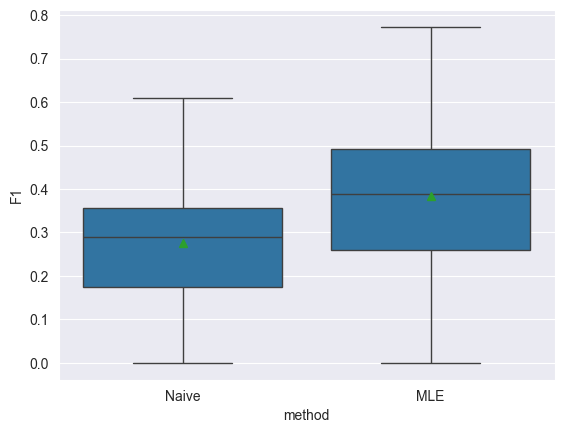

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='F1',
    showmeans=True
)

<Axes: xlabel='method', ylabel='Precision'>

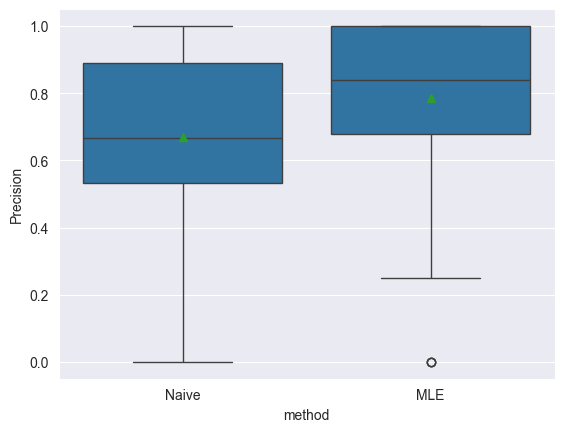

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='Precision',
    showmeans=True
)

<Axes: xlabel='method', ylabel='Recall'>

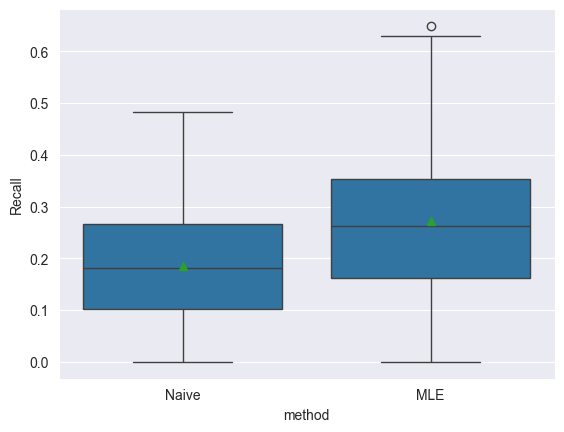

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='Recall',
    showmeans=True
)

<Axes: xlabel='method', ylabel='MSE_test'>

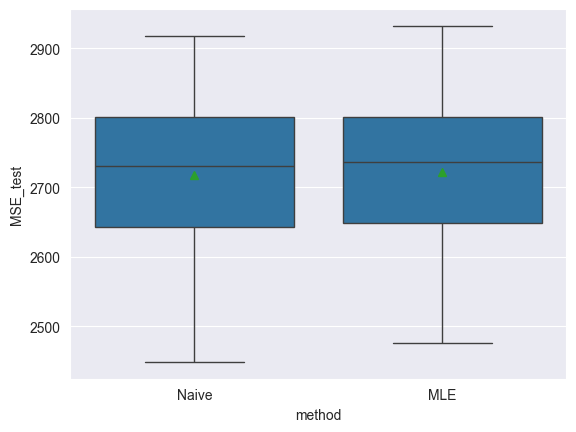

In [145]:
sns.boxplot(
    data=pd.DataFrame(MSE_dict),
    x='method',
    y='MSE_test',
    showmeans=True
)

<Axes: xlabel='method', ylabel='MSE_train'>

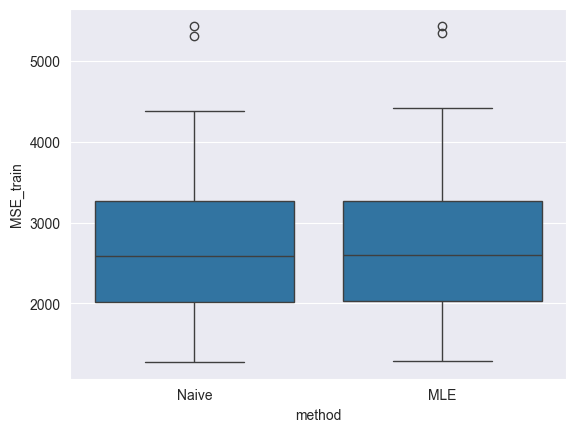

In [134]:
sns.boxplot(
    data=pd.DataFrame(MSE_dict),
    x='method',
    y='MSE_train'
)

In [135]:
y_test.std()**2

2457.5003734594484

In [136]:
interaction_freq_Naive, interaction_freq_MLE

({('distance', 'plane_age'): 3,
  ('distance', 'wind_dir'): 4,
  ('distance', 'sched_dep_hour'): 8,
  ('dewp', 'sched_dep_hour'): 6,
  ('humid', 'wind_dir'): 20,
  ('humid', 'sched_dep_hour'): 34,
  ('pressure', 'seats'): 35,
  ('pressure', 'wind_dir'): 33,
  ('pressure', 'visib'): 39,
  ('pressure', 'sched_dep_hour'): 20,
  ('plane_age', 'visib'): 30,
  ('seats', 'wind_dir'): 44,
  ('precip', 'visib'): 10,
  ('precip', 'sched_dep_hour'): 23,
  ('humid', 'visib'): 48,
  ('visib', 'sched_arr_hour'): 14,
  ('sched_dep_hour', 'sched_arr_hour'): 15,
  ('dewp', 'wind_speed'): 14,
  ('wind_dir', 'sched_dep_hour'): 14,
  ('pressure', 'sched_arr_hour'): 15,
  ('plane_age', 'wind_speed'): 12,
  ('seats', 'sched_dep_hour'): 17,
  ('wind_dir', 'sched_arr_hour'): 16,
  ('wind_speed', 'precip'): 12,
  ('wind_speed', 'sched_arr_hour'): 10,
  ('visib', 'sched_dep_hour'): 18,
  ('dewp', 'visib'): 14,
  ('humid', 'seats'): 24,
  ('humid', 'pressure'): 13,
  ('pressure', 'plane_age'): 13,
  ('pressure',

In [138]:
sorted(interaction_freq_Naive.items(), key=lambda kv: kv[1], reverse=True)

[(('humid', 'visib'), 48),
 (('seats', 'wind_dir'), 44),
 (('pressure', 'visib'), 39),
 (('pressure', 'seats'), 35),
 (('humid', 'sched_dep_hour'), 34),
 (('pressure', 'wind_dir'), 33),
 (('plane_age', 'visib'), 30),
 (('wind_dir', 'visib'), 28),
 (('humid', 'seats'), 24),
 (('precip', 'sched_dep_hour'), 23),
 (('wind_dir', 'wind_speed'), 21),
 (('humid', 'wind_dir'), 20),
 (('pressure', 'sched_dep_hour'), 20),
 (('visib', 'sched_dep_hour'), 18),
 (('seats', 'sched_dep_hour'), 17),
 (('wind_dir', 'sched_arr_hour'), 16),
 (('sched_dep_hour', 'sched_arr_hour'), 15),
 (('pressure', 'sched_arr_hour'), 15),
 (('plane_age', 'wind_dir'), 15),
 (('pressure', 'wind_speed'), 15),
 (('visib', 'sched_arr_hour'), 14),
 (('dewp', 'wind_speed'), 14),
 (('wind_dir', 'sched_dep_hour'), 14),
 (('dewp', 'visib'), 14),
 (('humid', 'pressure'), 13),
 (('pressure', 'plane_age'), 13),
 (('wind_speed', 'sched_dep_hour'), 13),
 (('plane_age', 'wind_speed'), 12),
 (('wind_speed', 'precip'), 12),
 (('seats', 'sc

In [139]:
sorted(interaction_freq_MLE.items(), key=lambda kv: kv[1], reverse=True)

[(('pressure', 'visib'), 56),
 (('humid', 'sched_dep_hour'), 54),
 (('dewp', 'sched_dep_hour'), 43),
 (('visib', 'sched_dep_hour'), 41),
 (('pressure', 'seats'), 40),
 (('seats', 'wind_dir'), 39),
 (('wind_dir', 'visib'), 38),
 (('dewp', 'visib'), 36),
 (('dewp', 'precip'), 35),
 (('wind_speed', 'sched_dep_hour'), 30),
 (('dewp', 'wind_dir'), 29),
 (('dewp', 'pressure'), 29),
 (('pressure', 'wind_dir'), 28),
 (('plane_age', 'visib'), 28),
 (('wind_dir', 'wind_speed'), 26),
 (('humid', 'visib'), 25),
 (('precip', 'visib'), 23),
 (('dewp', 'plane_age'), 22),
 (('pressure', 'wind_speed'), 22),
 (('pressure', 'sched_dep_hour'), 21),
 (('wind_speed', 'precip'), 20),
 (('dewp', 'seats'), 20),
 (('humid', 'wind_dir'), 18),
 (('wind_speed', 'sched_arr_hour'), 18),
 (('pressure', 'plane_age'), 18),
 (('dewp', 'humid'), 18),
 (('plane_age', 'wind_speed'), 17),
 (('plane_age', 'sched_dep_hour'), 16),
 (('temp', 'wind_speed'), 15),
 (('humid', 'wind_speed'), 15),
 (('seats', 'wind_speed'), 15),
 (

In [140]:
sorted(main_effects_freq_Naive.items(), key=lambda kv: kv[1], reverse=True)

[('sched_dep_hour', 97),
 ('pressure', 89),
 ('temp', 87),
 ('visib', 74),
 ('wind_speed', 69),
 ('wind_dir', 64),
 ('seats', 52),
 ('dewp', 38),
 ('sched_arr_hour', 30),
 ('precip', 29),
 ('plane_age', 21),
 ('distance', 9),
 ('humid', 0)]

In [141]:
sorted(main_effects_freq_MLE.items(), key=lambda kv: kv[1], reverse=True)

[('sched_dep_hour', 100),
 ('pressure', 85),
 ('temp', 75),
 ('wind_speed', 67),
 ('wind_dir', 66),
 ('visib', 59),
 ('dewp', 51),
 ('precip', 26),
 ('seats', 22),
 ('sched_arr_hour', 22),
 ('plane_age', 19),
 ('distance', 8),
 ('humid', 0)]